In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

In [2]:
with open("data/RPGF3/RPGF3_cleaned_applicant_data_final.json") as f:
    json_data = json.load(f)
mapping = {x['Project ID']:x['Project Name'] for x in json_data}

In [3]:
df = pd.read_csv("data/RPGF3/Lists/2023-12-04_consolidated_list_data.csv", index_col=0, header=1)
df = df.iloc[6:]

df['Name'] = [mapping[x] for x in df.index]
df['Name'] = df['Name'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
df.set_index('Name', drop=True, inplace=True)

oso_lists = [
    'Rising Stars',
    'Popular NPM Packages', 
    'Lean Protocols',
    'End User Experience & Adoption Projects on Open Source Observer',
    '🔺 Ecosystem Impact Vectors 🔺',
    'Developer Ecosystem Projects on Open Source Observer',
    'The Lindy List',
    'Bear Market Builders',
    'OSS Page Rank - Top 69 Results'
]
non_oso_lists = [c for c in df.columns if c not in oso_lists]

df_oso = df[oso_lists]

oso_projects = df_oso.sum(axis=1)
oso_projects = list(oso_projects[oso_projects>0].index)

df_oso = df_oso.loc[oso_projects,:]
df_non = df.loc[oso_projects,non_oso_lists]

print(f"Number of OSO projects: {len(oso_projects)}")

Number of OSO projects: 280


In [4]:
def make_table(cols):
    
    oso_wts = (
        (
            df_oso[cols].median(axis=1) 
            / 30000000
        )
        .rename("OSO Allocations")
    )
    projs = oso_wts[oso_wts>0].index
    non_wts = (
        (
            df_non.sum(axis=1)
            / df_non.sum(axis=1).sum()
        )
        .fillna(0)
        .rename("Other Allocations")
    )
    delta = (oso_wts - non_wts).rename("Delta")
    min_val = (oso_wts - delta).rename("Min")
    table = (
        pd.concat([oso_wts, non_wts, delta, min_val], axis=1)
        .sort_values(by='OSO Allocations')
    )
    table['abs'] = table['Delta'].apply(lambda x: abs(x))
    table = table[table['OSO Allocations'] > 0]
    if len(table) > 42:
        table = table.sort_values(by='abs').tail(42)
            
    table['Order'] = table['OSO Allocations'].rank(method='first')
    table.sort_values(by='Order', inplace=True)
    return table

def make_plot(table, title):
    
    Y = len(table)
    
    fig, ax = plt.subplots(figsize=(10,Y/4))
    sns.scatterplot(table, x='OSO Allocations', y='Order', color="Black", zorder=1, ax=ax)

    for name, row in table.iterrows():
        y = row['Order']
        x1 = row['Other Allocations']
        x2 = row['OSO Allocations']
        d = row['Delta']
        color = 'blue' if d > 0 else "#FFCCDD"
        l = mlines.Line2D([x1,x2], [y,y], color=color, zorder=0)
        ax.add_line(l)
        ax.text(s=f" {name}", x=max(x1,x2), y=y, va='center')

    ax.set_xlim(-.025,.075)    
    ax.set_ylim(-1,Y+1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(title)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from current font.
  func(*args, **kwargs)


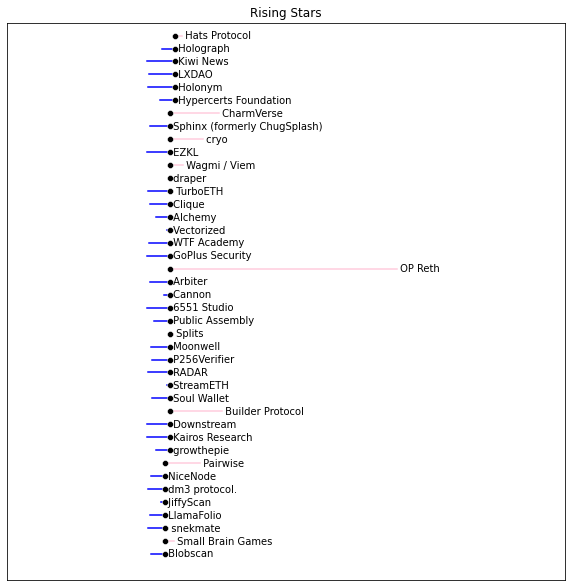

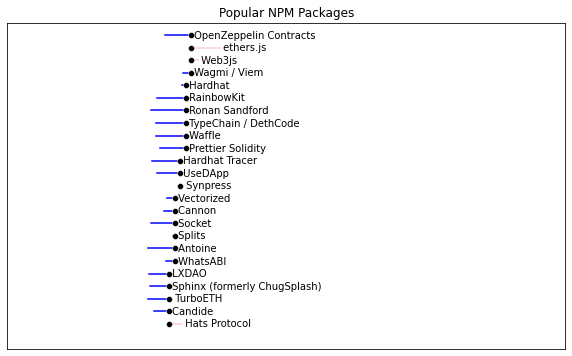

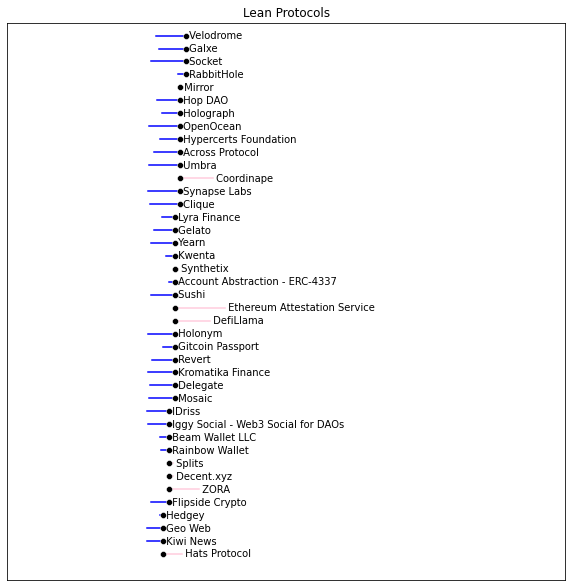

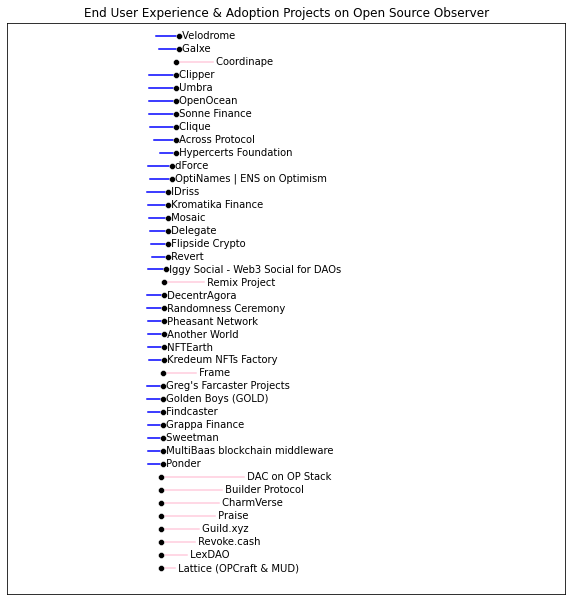

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


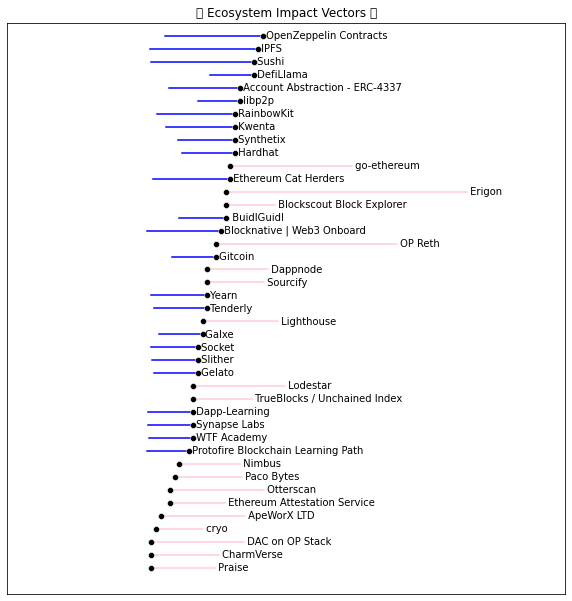

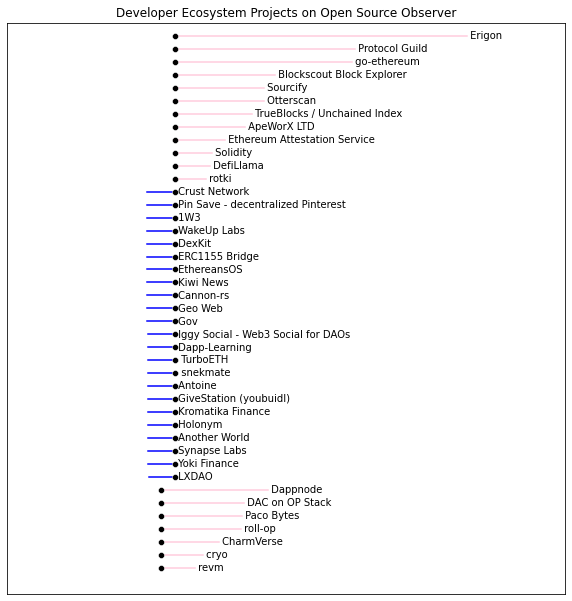

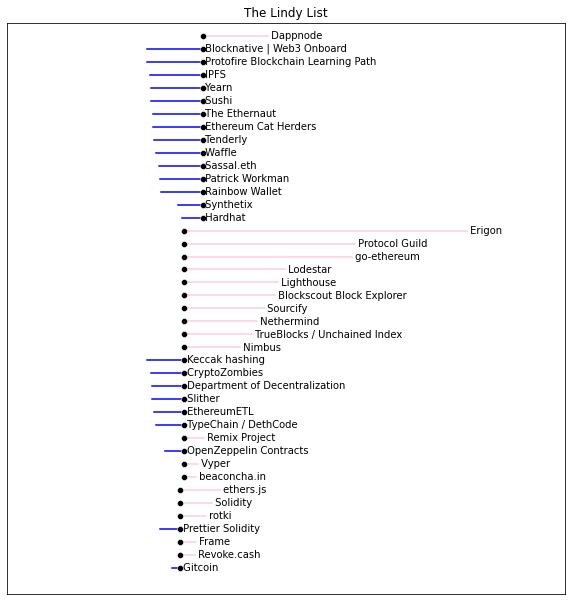

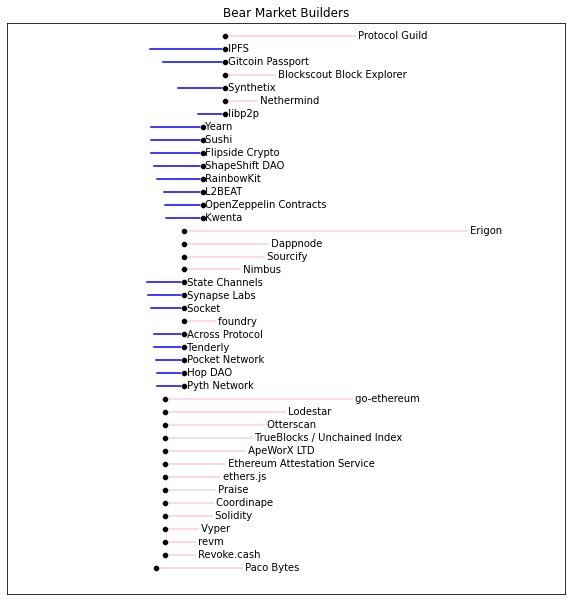

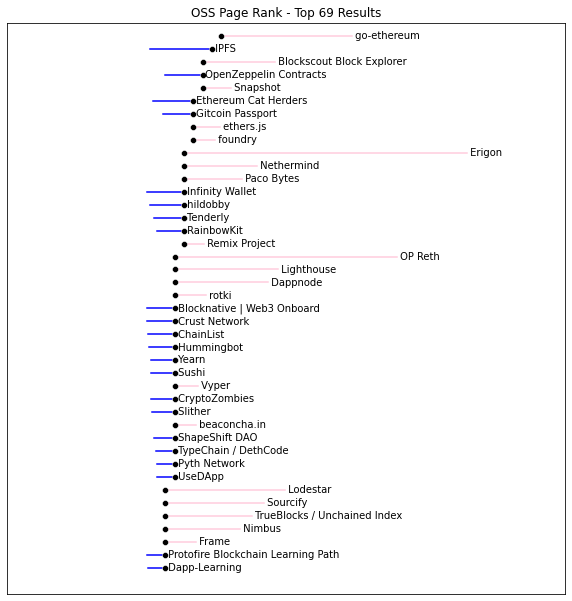

In [5]:
for lst in oso_lists:
    t = make_table([lst])
    make_plot(t, lst)